In [1]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

exec(open("ltco_utils.py", "r").read())

In [2]:
# -- set mpl defaults
plt.rcParams["image.interpolation"] = "nearest"

In [3]:
%matplotlib widget

In [4]:
# -- load the NOAA templates
dpath = "../output/"
noaa_names = np.load(dpath + "noaa_lab_spectra_names.npy", allow_pickle=True)
noaa = np.load(dpath + "noaa_lab_spectra.npy").T
waves_noaa = np.load(dpath + "noaa_lab_spectra_wavelengths.npy")

# -- load the LSPDD templates
lspdd_names = np.load(dpath + "lspdd_lab_spectra_names.npy", allow_pickle=True)
lspdd = np.load(dpath + "lspdd_lab_spectra.npy").T
waves_lspdd = np.load(dpath + "lspdd_lab_spectra_wavelengths.npy")

# -- load the quantum efficiency correction
qe = pd.read_csv("../data/hsi1-qe.csv", delimiter="\t")

# -- interpolate onto 2018 wavelengths
waves18 = get_wavelengths(2018)
wind = (waves18 >= np.max((waves_noaa.min(), waves_lspdd.min()))) & \
       (waves18 <= np.min((waves_noaa.max(), waves_lspdd.max())))
waves18 = waves18[wind]
noaa = np.array([np.interp(waves18, waves_noaa, i) for i in noaa])
lspdd = np.array([np.interp(waves18, waves_lspdd, i) for i in lspdd])
qe = np.interp(waves18, qe["wavelength_nm"], qe["quantum_efficiency"]) * 0.01

# -- merge all
templs = pd.DataFrame(data=np.hstack((noaa.T, lspdd.T)), columns=np.concatenate((noaa_names, lspdd_names)))


# -- filter combined list
corr = templs.multiply(qe, axis=0).corr() > 0.95

# -- recursively go through columns
fin = False
cols = templs.columns
ncol = len(cols)
cind = 0

while not fin:

    for jj in range(cind + 1, ncol):
        if corr.loc[cols[cind], cols[jj]]:
            templs.drop(columns=cols[jj], inplace=True)

    cind += 1
    cols = templs.columns
    ncol = len(cols)

    if cind == ncol:
        fin = True

# -- normalize
templs = (templs - templs.min(axis=0)) / (templs.max(axis=0) - templs.min(axis=0))

# -- clean column names
templs.columns = [i.replace("!", "1") for i in templs.columns]
templs.columns = [i.replace("100000000000K", "") for i in templs.columns]
templs.columns = [i.replace("-", "") for i in templs.columns]
templs.columns = [i.replace("Metal Halide", "") for i in templs.columns]
templs.columns = [i.replace("Low Pressure Sodium", "") for i in templs.columns]
templs.columns = [i.replace("Ledlight", "") for i in templs.columns]
templs.columns = [i.strip() for i in templs.columns]
templs.columns = [re.sub(" +", " ", i) for i in templs.columns]

# -- reorder columns
templs = templs[sorted(templs.columns)]


# -- add wavelengths
templs.insert(loc=0, column="wavelength", value=waves18)

# -- write out the results
np.save("../output/final_lab_spectra_names.npy", templs.columns[1:].values)
np.save("../output/final_lab_spectra.npy", templs[templs.columns[1:]].values)
np.save("../output/final_lab_spectra_wavelengths.npy", templs["wavelength"].values.astype(float))

reading and parsing night_00000.hdr...
reading night_00000.raw...


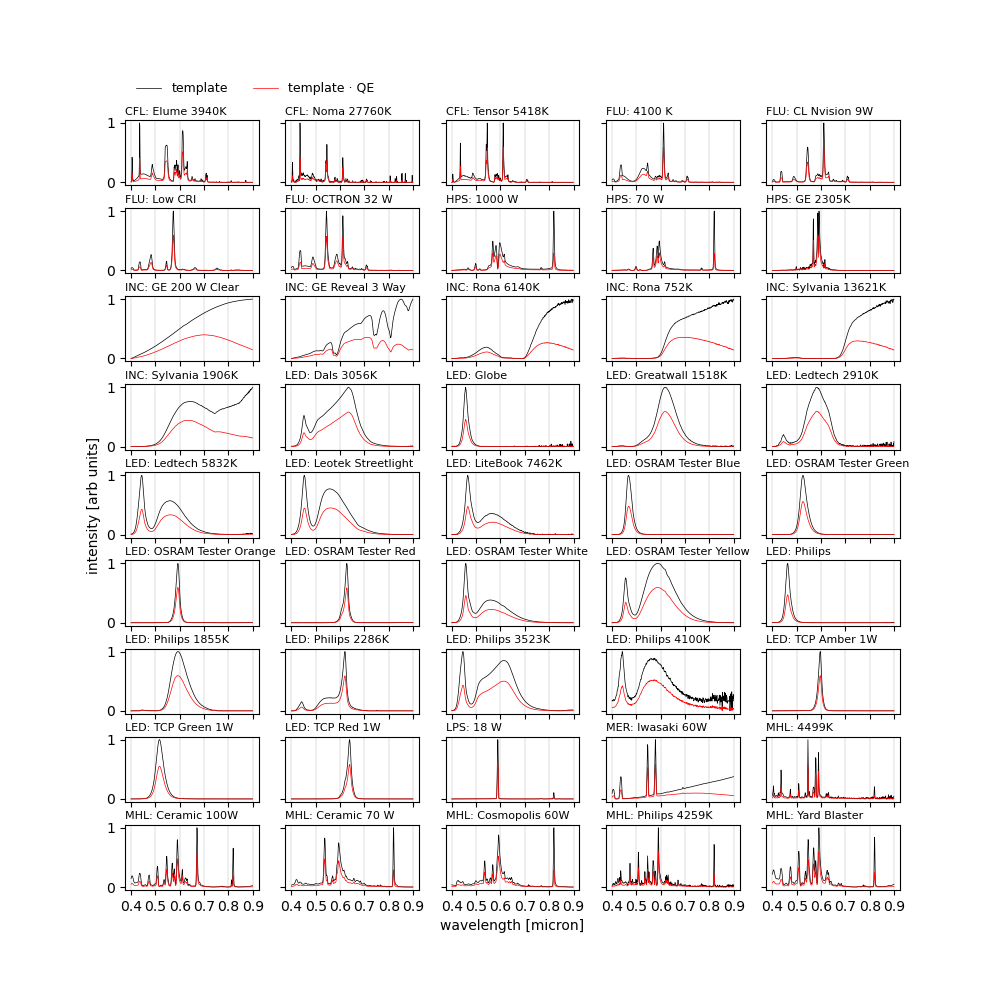

In [138]:
plt.close("all")
fig, ax = plt.subplots(9, 5, sharex=True, sharey=True, figsize=(10, 10))
for ii in range(45):
    tax = ax[ii // 5, ii % 5]
    tax.plot(templs.wavelength * 1e-3, templs[templs.columns[ii + 1]], "k", lw=0.5, label="template")
    tax.plot(templs.wavelength * 1e-3, templs[templs.columns[ii + 1]] * qe, "r", lw=0.5, label="template · QE")
    tax.set_title(templs.columns[ii + 1], loc="left", va="center", fontsize=8)
    tax.set_xticks(np.arange(0.4, 1.0, 0.1))
    tax.grid(":", axis="x", lw=0.3)
ax[0, 0].legend(fontsize=9, ncol=2, loc="upper left", frameon=False, bbox_to_anchor=(0.0, 1.75))
ax[4, 0].set_ylabel("intensity [arb units]")
ax[8, 2].set_xlabel("wavelength [micron]")
fig.subplots_adjust(hspace=0.35)